## Basic one-dimensional phase-field model (Allen-Cahn equation)
This python code was developed by Yamanaka research group of Tokyo University of Agriculture and Technology in August 2019.

## Problem
Let us consider an example: growth of phase B in phase A. 
This notebook shows one-dimensional phase-field simulation of the growth of phase B using Allen-Cahn equation. 

For details of the model, please see reference (*S. M. Allen and J. W. Cahn, "A Microscopic Theory for Antiphase Boundary Motion and Its Application to Antiphase Domain Coarsening," Acta Metallurgica, Vol. 27 (1979), pp. 1085–1095.*).
## Formulation
### 1. Order parameter
An non-conserved order parameter $\phi$ (hereafter, we call it as "phase-field variable".) is used. The phase-field variable $\phi$ is defined as $\phi = 0$ in phase A and $\phi = 1$ in phase B. The phase-field variable $\phi$ smoothly changes from 0 to 1 in an "diffuse" interfacial region. 
### 2. Total free energy
The total Gibbs free energy of the system is defined by
$$
G = \int_{V} (g_{chem}(\phi) + g_{doub}(\phi) + g_{grad}(\nabla\phi)) dV
$$
where, $g_{chem}$, $g_{doub}$, and $g_{grad}$ are the chemical free energy, the double-well potential energy and the gradient energy densities, respectively. In this source code, these energy densities are defined as follows: 
$$
g_{chem} = p(\phi)g_{B} + (1-p(\phi))g_{A}
$$
$$
g_{doub} = Wq(\phi)
$$
$$
g_{grad} = \frac{a^{2}}{2}|\nabla\phi|^{2}
$$
where $g_{A}$ and $g_{B}$ are Gibbs free energy densities of pure phase A and pure phase B, respectively. Here, $g_{A}$ and $g_{B}$ are assumed to be constant. 

$p(\phi)$ and $q(\phi)$ are an interpolation function and the double-well potential function. These functions are often defined as follows: 
$$
p(\phi) = \phi^{2}(3-2\phi)
$$
$$
q(\phi) = \phi^{2}(1-\phi)^{2}
$$

$W$ and $a$ are the height of double-well potential energy and the gradient energy coefficient, respectively, which are given by
$$
W = \frac{6\sigma\delta}{b}
$$
$$
a = \sqrt{\frac{3\sigma b}{\delta}}
$$
where $\sigma$ is the interfacial energy of an interface between phase A and B. $\delta$ is the thickness (length in one-dimension) of the diffuse interface. $b$ is given as $b = 2\tanh^{-1}(1-2\lambda)$ where $\lambda$ is a constant which is used for determining the thickness of interfacial region. In this source code, we use $\lambda$ = 0.1 and then $b$ = 2.2.  

### 3. Time evolution equation (Allen-Cahn equation)
The time evolution of the phase-field variable (that describes the migration of the interface) is given by Allen-Cahn equation by assuming that the total free energy of the system, $G$, decreases monotonically with time (i.e. The second law of thermodynamics): 
$$
\frac{\partial \phi}{\partial t} = -M_{\phi}\frac{\delta G}{\delta \phi}=-M_{\phi}\left(\frac{\partial p(\phi)}{\partial \phi}(g_{B}-g_{A})+W\frac{\partial q(\phi)}{\partial\phi}-a^{2}\nabla^{2}\phi\right)
$$
where $M_{\phi}$ is the mobility of phase-field variable and is given by: 
$$
M_{\phi} = \frac{\sqrt{2W}}{6a}M
$$
Here, $M$ is a "physical" mobility of interface between phase A and B. 
The term $g_{B}-g_{A}$ in the Allen-Cahn equation corresponds to the driving force of the growth of phase  B. 

Note that the <a href = "https://en.wikipedia.org/wiki/Functional_derivative">Euler-Lagrange equation</a> given by the following equation is used to calculate the functional derivative of $G$ with respect to the phase-field variable as:
$$
\frac{\delta G}{\delta \phi}=\frac{\partial g}{\partial \phi}-\nabla\cdot\frac{\partial g}{\partial (\nabla \phi)}
$$


## Programming 

### import libraries
In this notebook, you use NumPy, Matplotlib and Math libraries. 

Numpy is a fundamental package for scientific computing in Python that provides a multidimensional array object. <br>
Matplotlib is a Python library used for plotting the beautiful and attractive graphs and animations. <br>
Math is a library for accessing to some common math functions and constants in Python

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import math

### set parameters and physical values 

In [2]:
nx = 64 # number of computational grids
dx = 0.5e-6 # spacing of computational grid [m]
eee = 5.e+5 # magnitude of driving force of growth of phase B: g_A - g_B [J/m3] = [Pa]
sigma = 1.0 # ineterfacial energy [J/m2]
delta = 4.*dx # interfacial thickness [m]
amobi = 4.e-14 # interfacial mobilitiy [m4/(Js)]
ram = 0.1 # paraneter which deternines the interfacial area
bbb = 2.*np.log((1.+(1.-2.*ram))/(1.-(1.-2.*ram)))/2.  # The constant b = 2.1972 (please see the handout)

### calculate phase-field parameters ($a, W$ and $M_{\phi}$)

In [3]:
aaa   = np.sqrt(3.*delta*sigma/bbb) # gradient energy coefficient  "a"[(J/m)^(1/2)]
www   = 6.*sigma*bbb/delta # potential height W [J/m3]
pmobi = amobi*math.sqrt(2.*www)/(6.*aaa) # mobility of phase-field [m3/(Js)]

### define time increment and total number of time steps

In [4]:
dt = dx*dx/(5.*pmobi*aaa*aaa)/2 # time increment for a time step [s]
nsteps = 500 # total number of time step

### declare arrays for phase field variable and others

In [5]:
p  = np.zeros((nsteps,nx)) # phase-field variable for all time steps
driv = np.zeros((nsteps,nx)) # array for saving driving force term (only for visualization)
grad = np.zeros((nsteps,nx)) # array for saving gradient force term (only for visualization)

### set initial distribution of phase-field variable (initial nuclei of phase B)
The initial nuclei of the phase B (region of $\phi = 1$) is located at the origin of the computational domain. 

The initial profile of the phase-field variable along $x$-direction is calculated using the equilibrium profile (see Appendix in the handout for the derivation): 
$$
\phi = \frac{1}{2}\left(1-\tanh \frac{\sqrt{2W}}{2a}(x-r_{0})  \right)
$$
where $r_{0}$ denotes the initial position of the interface. 

In [6]:
r_nuclei = 10.*dx # length of the initial B phase
for i in range(0,nx):
        r = i*dx - r_nuclei
        p[0,i] = 0.5*(1.-np.tanh(np.sqrt(2.*www)/(2.*aaa)*r))

### define function for solving Allen-Cahn equation
Allen-Cahn equation is discretized by simple finite difference method in this program. 

The 1st-order foward Euler method is used for the time-integration. The 2nd-order central finite difference method is used for the spatial derivatives. The discretized Allen-Cahn equation is given as: 
$$
\phi^{t+\Delta t}_{i} = \phi^{t}_{i} + M_{\phi}
\left[ 4W\phi^{t}_{i}\left(1-\phi^{t}_{i}\right)\left(\phi^{t}_{i}-\frac{1}{2}+\frac{3}{2W}(g_{A}-g_{B})\right)
+a^{2}\left(\frac{\phi^{t}_{i+1}-2\phi^{t}_{i}+\phi^{t}_{i-1}}{(\Delta x)^{2}}\right)
\right]\Delta t
$$

For visuallization, arrays "driv" and "grad" are saved. 

In [7]:
def do_timestep(p,driv,grad):
    for t in range(nsteps-1):
        for i in range(nx):
            ip = i + 1
            im = i - 1
            if ip > nx - 1:
                ip = nx -1
            if im < 0:
                im = 0
            p[t+1,i] = p[t,i] + pmobi * ( 4.*www*p[t,i]*(1.-p[t,i])*(p[t,i]-0.5+3./(2.*www)*eee) +  aaa*aaa*((p[t,ip] - 2*p[t,i] + p[t,im])/dx/dx) ) * dt
            driv[t+1,i] = pmobi*(4.*www*p[t,i]*(1.-p[t,i])*(p[t,i]-0.5+3./(2.*www)*eee))
            grad[t+1,i] = pmobi*(aaa*aaa*(p[t,ip] - 2*p[t,i] + p[t,im])/dx/dx)

### Time integration of Allen-Cahn equation and real-time visualization
Check the role of driving force and gradient terms in Allen-Cahn equation. 

The driving force tem: 
$$
M_{\phi}\left[ 4W\phi^{t}_{i}\left(1-\phi^{t}_{i}\right)\left(\phi^{t}_{i}-\frac{1}{2}+\frac{3}{2W}(g_{A}-g_{B})\right) \right]
$$
The gradient (or diffusion) term:
$$
M_{\phi}\left[ a^{2}\left(\frac{\phi^{t}_{i+1}-2\phi^{t}_{i}+\phi^{t}_{i-1}}{(\Delta x)^{2}}\right)  \right]
$$


<IPython.core.display.Javascript object>


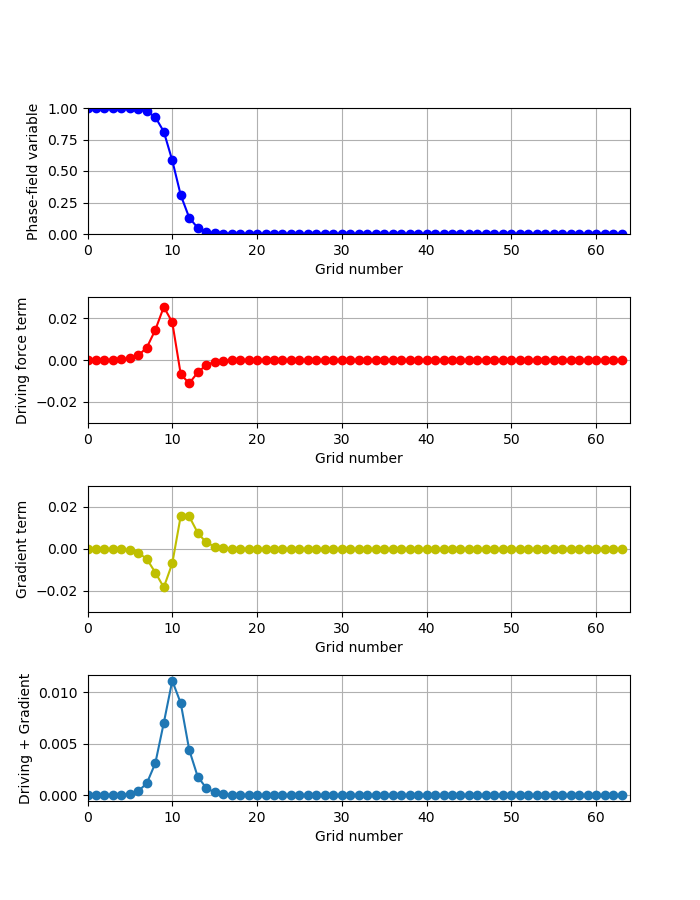

In [8]:
# calculate Allen-Cahn equation for "nsteps" times
do_timestep(p,driv,grad)

# visualize the result
fig = plt.figure(figsize=(7,9))
fig.set_dpi(100)
plt.subplots_adjust(hspace=0.5)
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4)

def animate(i):
    ax1.clear()
    plt.subplot(4, 1, 1)
    plt.ylim([0,1])
    plt.xlim([0,nx])
    plt.xlabel('Grid number')
    plt.ylabel('Phase-field variable')
    plt.grid(True)
    plt.plot(p[i,:],color="b",marker="o")
    ax2.clear()
    plt.subplot(4, 1, 2)
    plt.ylim([-0.03,0.03])
    plt.xlim([0,nx])
    plt.xlabel('Grid number')
    plt.ylabel('Driving force term')
    plt.grid(True)
    plt.plot(driv[i,:],color="r",marker="o")
    ax3.clear()
    plt.subplot(4, 1, 3)
    plt.ylim([-0.03,0.03])
    plt.xlim([0,nx])
    plt.xlabel('Grid number')
    plt.ylabel('Gradient term')
    plt.grid(True)
    plt.plot(grad[i,:],color="y",marker="o")
    ax4.clear()
    plt.subplot(4, 1, 4)
    plt.xlim([0,nx])
    plt.xlabel('Grid number')
    plt.ylabel('Driving + Gradient')
    plt.grid(True)
    plt.plot(grad[i,:]+driv[i,:],marker="o")
    
anim = animation.FuncAnimation(fig,animate,frames=nsteps-1,interval=100,repeat=False)
plt.show()